# A2C, Advantage Actor Critic

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
from model import PolicyNetwork, ValueNetwork, HybridNetwork

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
GAMMA = 0.99
LR = 1e-4
PRINT_EVERY = 100

## Set Environment

In [7]:
ENV_NAME = 'LunarLander-v2'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(8,)
Action space Discrete(4)


## Define [A2C](https://arxiv.org/pdf/1602.01783.pdf) Agent

In [9]:
class A2CAgent():
    
    def __init__(self, env, seed):
        
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.hidden_size = 256
        self.action_size = env.action_space.n
        
        self.gamma = GAMMA
        self.lr = LR
        
        # initialize actor and critic networks
        self.actor = PolicyNetwork(self.state_size, self.hidden_size, self.action_size, seed).to(device)
        self.critic = ValueNetwork(self.state_size, self.hidden_size, 1, seed).to(device)
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr)
        
    def act(self, state):
        
        state = torch.FloatTensor(state).to(device)
        probs = self.actor(state)
        m = Categorical(probs)
        
        action = m.sample()
        
        return action.cpu().detach().item()
    
    def learn(self, trajectory):
        
        policy_loss, value_loss = self.compute_loss(trajectory)
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()
        
        return policy_loss, value_loss
    
    def compute_loss(self, trajectory):
        
        states = torch.FloatTensor([sarsd[0] for sarsd in trajectory])
        states = states.to(device)
        
        actions = torch.LongTensor([sarsd[1] for sarsd in trajectory]).view(-1, 1)
        actions = actions.to(device)
        
        rewards = torch.FloatTensor([sarsd[2] for sarsd in trajectory])
        rewards = rewards.to(device)
        
        next_states = torch.FloatTensor([sarsd[3] for sarsd in trajectory])
        next_states = next_states.to(device)
        
        dones = torch.FloatTensor([sarsd[4] for sarsd in trajectory]).float().view(-1, 1)
        dones = dones.to(device)
        
        # compute value target
        discounted_rewards = [torch.sum(torch.FloatTensor([self.gamma**i for i in \
                              range(rewards[j:].size(0))]) * rewards[j:]) for j in range(rewards.size(0))]
        
        value_targets = rewards.view(-1, 1) + torch.FloatTensor(discounted_rewards).view(-1, 1).to(device)
        
        # compute value loss
        values = self.critic(states)
        value_loss = F.mse_loss(value_targets.detach(), values)
        
        # compute policy loss with entropy bonus
        probs = self.actor(states)
        m = Categorical(probs)
        
        # compute entropy bonus
        entropy = []
        for prob in probs:
            entropy.append(-torch.sum(prob.mean() * torch.log(prob)))
        entropy = torch.stack(entropy).sum()
        
        # compute advantage function to calculate the extra reward get by agent and to avoid high variability
        advantage = value_targets - values
        policy_loss = -m.log_prob(actions.view(actions.size(0))).view(-1, 1) * advantage.detach()
        policy_loss = policy_loss.mean() - 0.001 * entropy
        
        return policy_loss, value_loss
    
    def save(self, actor_path, critic_path):
        
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        torch.save(self.actor.state_dict(), actor_path); torch.save(self.critic.state_dict(), critic_path)
        
    def watch(self, num_episodes):
        
        for i_episode in range(1, num_episodes+1):
    
            state = env.reset()
            rewards = []
            for time_step in range(1000):

                env.render() # render the screen

                action = self.act(state) # select an action
                next_state, reward, done, _ = env.step(action)

                state = next_state
                rewards.append(reward)
                if done:
                    break

            print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

        env.close()

In [10]:
agent = A2CAgent(env, seed=90)

## Train The Agent

In [11]:
def train_agent(num_episodes=1000, max_time=5000):
    
    scores = []
    policy_loss_plot = []; value_loss_plot = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, num_episodes+1):
        
        state = env.reset()
        score = 0
        
        trajectory = []
        
        for time_step in range(max_time):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            trajectory.append([state, action, reward, next_state, done])
            
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        
        policy_loss, value_loss = agent.learn(trajectory)
        policy_loss_plot.append(policy_loss); value_loss_plot.append(value_loss)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}, Policy Loss: {policy_loss:2f}, Value Loss: {value_loss:2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}, Policy Loss: {policy_loss:2f}, Value Loss: {value_loss:2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}, Policy Loss: {policy_loss:2f}, Value Loss: {value_loss:2f}')
            break
            
    agent.save(f'./agents/ACTOR_{ENV_NAME}.pth', f'./agents/CRITIC_{ENV_NAME}.pth')
    print('Training completed.')
    
    return scores, policy_loss_plot, value_loss_plot

In [12]:
scores, policy_loss, value_loss = train_agent(num_episodes=2000, max_time=500)

Episode: 100, Average Score: -267.49, Policy Loss: -155.593948, Value Loss: 13016.175781
Episode: 200, Average Score: -274.02, Policy Loss: -117.430557, Value Loss: 7558.11474608
Episode: 300, Average Score: -306.38, Policy Loss: -400.759674, Value Loss: 85902.6796888
Episode: 400, Average Score: -322.26, Policy Loss: -362.121246, Value Loss: 68163.6406250
Episode: 500, Average Score: -329.58, Policy Loss: -460.398621, Value Loss: 112523.960938
Episode: 600, Average Score: -383.53, Policy Loss: -268.212860, Value Loss: 33101.1171880
Episode: 700, Average Score: -393.72, Policy Loss: -432.785278, Value Loss: 83620.37500062
Episode: 800, Average Score: -436.91, Policy Loss: -796.960754, Value Loss: 70853.21875038
Episode: 900, Average Score: -488.24, Policy Loss: -1156.473511, Value Loss: 123140.562500
Episode: 1000, Average Score: -471.69, Policy Loss: -1268.365601, Value Loss: 102489.398438
Episode: 1100, Average Score: -523.25, Policy Loss: -742.609314, Value Loss: 49892.44921900
Epis

## Evaluate The Agent

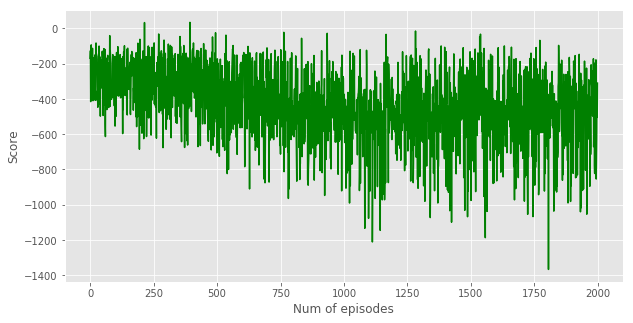

In [13]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_a2c_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agen

In [14]:
agent.watch(num_episodes=10)

Episode: 1, Average Score: -318.91
Episode: 2, Average Score: -498.06
Episode: 3, Average Score: -254.48
Episode: 4, Average Score: -424.33
Episode: 5, Average Score: -170.58
Episode: 6, Average Score: -548.35
Episode: 7, Average Score: -260.17
Episode: 8, Average Score: -307.19
Episode: 9, Average Score: -566.36
Episode: 10, Average Score: -422.94


---